<a href="https://colab.research.google.com/github/hongsukyi/quantum/blob/main/tch_stepQNN_colab_ok4_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. minmaxscaler 추가 함. -1에서 1 사이
2. scaler 범위
-  입력(X) 스케일러: [-π, π] → QNN 회전 게이트용
- 출력(y) 스케일러: [-1, 1] → QNN expectation 범위에 맞춤

Python version: 3.12.11
Qiskit version: 1.4.4
Qiskit Machine Learning version: 0.8.3
TensorFlow version: 2.19.0
PyTorch version: 2.8.0+cu126
Using device: cuda
🚀 QNN 기반 시계열 예측 모델 (Quantum Neural Network)

📊 1. 데이터 로드 및 전처리...
원본 데이터 통계:
- 최소 속도: 37.00 km/h
- 최대 속도: 73.60 km/h
- 평균 속도: 51.38 km/h
- 데이터 길이: 288


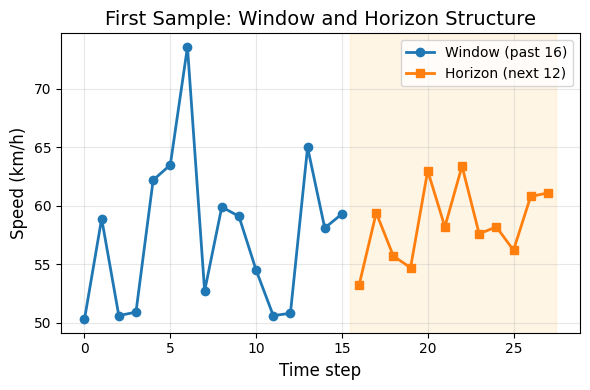


스케일링 후 데이터 통계:
X - Min: -3.14159, Max: 3.14159, Mean: -0.73629
y - Min: -1.00000, Max: 1.00000, Mean: -0.19806
데이터 형태: X(261, 16), y(261, 12)

스케일러 정보:
X_scaler - Data range: [37.00, 73.60] km/h
y_scaler - Data range: [37.00, 71.30] km/h

데이터 분할 결과:
Train: Xtorch.Size([166, 16]), ytorch.Size([166, 12])
Validation: Xtorch.Size([42, 16]), ytorch.Size([42, 12])
Test: Xtorch.Size([53, 16]), ytorch.Size([53, 12])

🔬 2. 양자 신경망(QNN) 생성...
QNN 생성 완료: 4 qubits, 3 reps
- Input parameters: 4
- Weight parameters: 32

🧠 3. QNN + Attention 모델 생성...

📈 모델 정보:
- 총 파라미터 수: 42
- Device: cuda
- Window: 16, Horizon: 12
- Batch Size: 32, Learning Rate: 0.01

🔥 4. 모델 학습 시작... (Epochs: 10)
------------------------------------------------------------


In [ ]:
import sys

# Google Colab 환경 여부 확인 및 패키지 설치
if "google.colab" in sys.modules:
    !pip install qiskit==1.4.4
    !pip install qiskit_machine_learning==0.8.3
    !pip install pylatexenc
else:
    print("Colab 환경이 아니므로 설치를 건너뜁니다.")

# 필요한 라이브러리 임포트
from platform import python_version
import qiskit
import qiskit_machine_learning
import tensorflow as tf
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings

# Qiskit 관련
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

warnings.filterwarnings("ignore", category=DeprecationWarning)

# 버전 확인
print(f"Python version: {python_version()}")
print(f"Qiskit version: {qiskit.__version__}")
print(f"Qiskit Machine Learning version: {qiskit_machine_learning.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")

# Device 설정 (CUDA 사용 가능 시 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# 하이퍼파라미터 설정
# =============================================================================
WINDOW =  16              # 입력 시퀀스 길이
HORIZON = 12             # 예측할 미래 시점 수 (1 또는 그 이상)
N_QUBITS = 4             # 큐비트 수
EPOCHS = 10              # 학습 에포크 수
TEACHER_FORCING_RATIO = 0.5  # Teacher forcing 비율
BATCH_SIZE = 32            # 배치 크기
LEARNING_RATE = 0.01       # 학습률

# =============================================================================
# 데이터 로드 및 전처리
# =============================================================================
def load_and_preprocess_data():
    """데이터를 로드하고 전처리하는 함수"""
    # 데이터 로드
    df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")
    df = df[:288]  # 데이터 크기 제한
    speed = df["Speed"].values

    print(f"원본 데이터 통계:")
    print(f"- 최소 속도: {speed.min():.2f} km/h")
    print(f"- 최대 속도: {speed.max():.2f} km/h")
    print(f"- 평균 속도: {speed.mean():.2f} km/h")
    print(f"- 데이터 길이: {len(speed)}")

    # 첫 번째 샘플 시각화를 위한 원본 데이터 생성
    X_orig, y_orig = create_dataset(speed, WINDOW, HORIZON)

    # 샘플 예측 시각화
    plt.figure(figsize=(6, 4))
    plt.plot(range(WINDOW), X_orig[0], label=f"Window (past {WINDOW})", marker='o', linewidth=2)
    plt.plot(range(WINDOW, WINDOW+HORIZON), y_orig[0], label=f"Horizon (next {HORIZON})", marker="s", linewidth=2)

    plt.title("First Sample: Window and Horizon Structure", fontsize=14)
    plt.xlabel("Time step", fontsize=12)
    plt.ylabel("Speed (km/h)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axvspan(WINDOW-0.5, WINDOW+HORIZON-0.5, color="orange", alpha=0.1, label="Prediction Zone")
    plt.tight_layout()
    plt.show()

    return speed

def create_dataset(series, window=WINDOW, horizon=HORIZON):
    """시계열 데이터를 window-horizon 형태로 변환"""
    X, y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i:i+window])
        y.append(series[i+window:i+window+horizon])
    return np.array(X), np.array(y)

def prepare_scalers_and_data(speed):
    """스케일러 준비 및 데이터 변환 - 이중 스케일링 문제 해결"""
    # 원본 데이터에서 X, y 생성 (스케일링 전)
    X_orig, y_orig = create_dataset(speed, WINDOW, HORIZON)

    # 스케일러 설정
    # X: [-π, π] 범위로 스케일링 (QNN 회전 게이트용)
    # y: [-1, 1] 범위로 스케일링 (QNN expectation 범위)
    X_scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))

    # 각각 독립적으로 스케일링 (원본 데이터 기준)
    X_scaler.fit(X_orig.reshape(-1, 1))
    y_scaler.fit(y_orig.reshape(-1, 1))

    X_scaled = X_scaler.transform(X_orig.reshape(-1, 1)).reshape(X_orig.shape)
    y_scaled = y_scaler.transform(y_orig.reshape(-1, 1)).reshape(y_orig.shape)

    print(f"\n스케일링 후 데이터 통계:")
    print(f"X - Min: {X_scaled.min():.5f}, Max: {X_scaled.max():.5f}, Mean: {X_scaled.mean():.5f}")
    print(f"y - Min: {y_scaled.min():.5f}, Max: {y_scaled.max():.5f}, Mean: {y_scaled.mean():.5f}")
    print(f"데이터 형태: X{X_scaled.shape}, y{y_scaled.shape}")

    print(f"\n스케일러 정보:")
    print(f"X_scaler - Data range: [{X_scaler.data_min_[0]:.2f}, {X_scaler.data_max_[0]:.2f}] km/h")
    print(f"y_scaler - Data range: [{y_scaler.data_min_[0]:.2f}, {y_scaler.data_max_[0]:.2f}] km/h")

    return X_scaled, y_scaled, X_scaler, y_scaler

def split_data(X, y):
    """데이터를 train/validation/test로 분할"""
    # Train/Test 분할 (시간 순서 유지)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Train/Validation 분할
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, shuffle=False
    )

    # PyTorch tensor로 변환
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"\n데이터 분할 결과:")
    print(f"Train: X{X_train.shape}, y{y_train.shape}")
    print(f"Validation: X{X_val.shape}, y{y_val.shape}")
    print(f"Test: X{X_test.shape}, y{y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

def create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test):
    """DataLoader 생성"""
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

# =============================================================================
# 양자 신경망(QNN) 정의
# =============================================================================
def create_qnn(num_qubits=N_QUBITS, reps=3):
    """EfficientSU2를 사용한 QNN 생성"""
    # Feature Map (데이터 인코딩)
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)

    # Ansatz (학습 가능한 회로)
    ansatz = EfficientSU2(num_qubits, reps=reps)

    # 전체 회로 조합
    qc = feature_map.compose(ansatz)

    # QNN 정의
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,   # 입력 파라미터
        weight_params=ansatz.parameters        # 학습 파라미터
    )

    print(f"QNN 생성 완료: {num_qubits} qubits, {reps} reps")
    print(f"- Input parameters: {len(feature_map.parameters)}")
    print(f"- Weight parameters: {len(ansatz.parameters)}")

    return qnn, qc

# =============================================================================
# Attention 기반 QNN 모델
# =============================================================================
class StepwiseQNNWithAttention(nn.Module):
    """단계별 QNN과 Attention을 결합한 모델"""

    def __init__(self, window, qnn_layer, n_qubits, qnn_outdim=1, attn_heads=1):
        super().__init__()
        self.window = window
        self.qnn_layer = qnn_layer
        self.n_qubits = n_qubits
        self.qnn_outdim = qnn_outdim

        # Multi-head Attention
        self.attn = nn.MultiheadAttention(
            embed_dim=qnn_outdim,
            num_heads=attn_heads,
            batch_first=True
        )

        # 최종 출력 레이어
        self.fc = nn.Linear(qnn_outdim, 1)

    def forward(self, x):
        """
        Args:
            x: (batch_size, window) 형태의 입력
        Returns:
            (batch_size, 1) 형태의 예측값
        """
        qnn_outs = []

        # 입력을 n_qubits 단위로 분할하여 QNN에 입력
        for t in range(0, self.window, self.n_qubits):
            step_in = x[:, t:t+self.n_qubits]  # (batch, n_qubits)
            qnn_out = self.qnn_layer(step_in)  # (batch, qnn_outdim)
            qnn_outs.append(qnn_out.unsqueeze(1))  # (batch, 1, qnn_outdim)

        # QNN 출력 시퀀스 생성
        qnn_seq = torch.cat(qnn_outs, dim=1)  # (batch, seq_len, qnn_outdim)

        # Self-attention 적용
        attn_out, _ = self.attn(qnn_seq, qnn_seq, qnn_seq)
        attn_out = attn_out.mean(dim=1)  # (batch, qnn_outdim)

        # 최종 예측
        return self.fc(attn_out)  # (batch, 1)

# =============================================================================
# 학습 및 평가 함수
# =============================================================================
def rollout_autoregressive(model, X, horizon, teacher_forcing=False, y=None):
    """Autoregressive rollout을 통한 다중 시점 예측"""
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)

    # Device 정보를 X에서 가져옴
    device = X.device

    preds = []
    input_seq = X.clone()  # (batch, window)

    for t in range(horizon):
        pred = model(input_seq)  # (batch, 1)
        preds.append(pred)

        # Teacher forcing 또는 예측값 사용
        if teacher_forcing and y is not None:
            # y의 차원에 따라 다르게 처리
            if horizon == 1:
                if y.dim() == 1:  # (batch,)
                    next_input = y.unsqueeze(-1)  # (batch, 1)
                else:  # (batch, 1) or (batch, horizon)
                    next_input = y[:, 0].unsqueeze(-1) if y.size(1) > 0 else y
            else:
                if y.dim() == 2 and t < y.size(1):  # (batch, horizon)
                    next_input = y[:, t].unsqueeze(-1)
                elif y.dim() == 3 and t < y.size(1):  # (batch, horizon, 1)
                    next_input = y[:, t, 0].unsqueeze(-1)
                else:
                    next_input = pred.detach()
        else:
            next_input = pred.detach()

        # 입력 시퀀스 업데이트 (sliding window) - 마지막 단계가 아닌 경우에만
        if t < horizon - 1:
            input_seq = torch.cat([input_seq[:, 1:], next_input], dim=1)

    # 결과 결합
    result = torch.cat(preds, dim=1)  # (batch, horizon)

    # horizon=1인 경우 차원 조정 옵션
    if horizon == 1 and result.size(1) == 1:
        return result  # (batch, 1) 유지 또는 squeeze하여 (batch,)로 반환할지는 호출하는 쪽에서 결정

    return result

def train_autoregressive(model, dataloader, criterion, optimizer, device,
                        teacher_forcing_ratio=TEACHER_FORCING_RATIO, horizon=HORIZON):
    """Autoregressive 방식으로 모델 학습"""
    model.train()
    total_loss = 0.0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # y의 차원 정규화: (batch, horizon) 형태로 통일
        if y.dim() == 3 and y.size(-1) == 1:  # (batch, horizon, 1)
            y = y.squeeze(-1)  # -> (batch, horizon)
        elif y.dim() == 2 and horizon == 1 and y.size(1) == 1:  # (batch, 1)
            y = y.squeeze(-1)  # -> (batch,)
        elif y.dim() == 1 and horizon > 1:  # (batch,) but horizon > 1
            y = y.unsqueeze(-1)  # -> (batch, 1)

        optimizer.zero_grad()
        loss = 0.0

        input_seq = X.clone()

        # 각 시점별로 예측 및 손실 계산
        for t in range(horizon):
            pred = model(input_seq).squeeze(-1)  # (batch,)

            # Teacher forcing 결정
            use_teacher_forcing = (torch.rand(1).item() < teacher_forcing_ratio)

            # y에서 현재 시점의 target 값 추출
            if horizon == 1:
                current_target = y if y.dim() == 1 else y[:, 0] if y.dim() == 2 else y
            else:
                current_target = y[:, t] if t < y.size(1) else pred.detach()

            # Teacher forcing 적용
            if use_teacher_forcing and t < (y.size(1) if y.dim() > 1 else 1):
                if horizon == 1:
                    next_input = (y if y.dim() == 1 else y[:, 0]).unsqueeze(-1)
                else:
                    next_input = y[:, t].unsqueeze(-1)
            else:
                next_input = pred.unsqueeze(-1).detach()

            # 입력 시퀀스 업데이트 (autoregressive)
            if t < horizon - 1:  # 마지막 단계가 아닌 경우에만 업데이트
                input_seq = torch.cat([input_seq[:, 1:], next_input], dim=1)

            # 손실 누적
            loss += criterion(pred, current_target)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() / horizon

    return total_loss / len(dataloader)

def evaluate_autoregressive(model, dataloader, criterion, device, horizon=HORIZON):
    """모델 평가"""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # y의 차원 정규화: (batch, horizon) 형태로 통일
            if y.dim() == 3 and y.size(-1) == 1:  # (batch, horizon, 1)
                y = y.squeeze(-1)  # -> (batch, horizon)
            elif y.dim() == 2 and horizon == 1 and y.size(1) == 1:  # (batch, 1)
                y = y.squeeze(-1)  # -> (batch,)
            elif y.dim() == 1 and horizon > 1:  # (batch,) but horizon > 1
                y = y.unsqueeze(-1)  # -> (batch, 1)

            preds = rollout_autoregressive(model, X, horizon=horizon, teacher_forcing=False)

            # 예측값도 target과 동일한 차원으로 맞춤
            if horizon == 1:
                if preds.dim() == 2 and preds.size(1) == 1:
                    preds = preds.squeeze(-1)  # (batch, 1) -> (batch,)

            loss = criterion(preds, y)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# =============================================================================
# 시각화 함수
# =============================================================================
def plot_training_history(train_losses, val_losses):
    """학습 과정 시각화"""
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2)
    plt.plot(val_losses, label="Validation Loss", marker='s', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("MSE Loss", fontsize=12)
    plt.title("Training & Validation Loss", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_sample_prediction(model, test_loader, X_scaler, y_scaler, device,
                          window=WINDOW, horizon=HORIZON):
    """샘플 예측 결과 시각화 (원본 스케일로 복원)"""
    model.eval()

    with torch.no_grad():
        X_batch, y_batch = next(iter(test_loader))
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # 예측 수행
        preds = rollout_autoregressive(model, X_batch, horizon=horizon, teacher_forcing=False)

        # 첫 번째 샘플 선택
        sample_idx = 0
        X_sample = X_batch[sample_idx].cpu().numpy().reshape(-1, 1)

        # y와 pred의 차원을 horizon에 맞게 처리
        if horizon == 1:
            if y_batch.dim() == 3:  # (batch, 1, 1)
                y_true = y_batch[sample_idx].cpu().numpy().reshape(-1, 1)
            elif y_batch.dim() == 2 and y_batch.size(1) == 1:  # (batch, 1)
                y_true = y_batch[sample_idx].cpu().numpy().reshape(-1, 1)
            else:  # (batch,)
                y_true = y_batch[sample_idx].cpu().numpy().reshape(-1, 1)

            if preds.dim() == 2:  # (batch, 1)
                y_pred = preds[sample_idx].cpu().numpy().reshape(-1, 1)
            else:  # (batch,)
                y_pred = preds[sample_idx].cpu().numpy().reshape(-1, 1)
        else:
            # horizon > 1인 경우
            if y_batch.dim() == 3:  # (batch, horizon, 1)
                y_true = y_batch[sample_idx].cpu().numpy().reshape(-1, 1)
            else:  # (batch, horizon)
                y_true = y_batch[sample_idx].cpu().numpy().reshape(-1, 1)

            if preds.dim() == 2:  # (batch, horizon)
                y_pred = preds[sample_idx].cpu().numpy().reshape(-1, 1)
            else:
                y_pred = preds[sample_idx].cpu().numpy().reshape(-1, 1)

        # 스케일 복원
        X_sample_orig = X_scaler.inverse_transform(X_sample).flatten()
        y_true_orig = y_scaler.inverse_transform(y_true).flatten()
        y_pred_orig = y_scaler.inverse_transform(y_pred).flatten()

        # 길이 검증 및 조정
        min_len = min(len(y_true_orig), len(y_pred_orig), horizon)
        y_true_orig = y_true_orig[:min_len]
        y_pred_orig = y_pred_orig[:min_len]

        # 시각화
        plt.figure(figsize=(6, 4))

        # 과거 데이터 (입력 윈도우)
        plt.plot(range(window), X_sample_orig, 'b-', linewidth=2, label="Input Window", marker='o', markersize=6)

        # 예측 구간 음영
        plt.axvspan(window-0.5, window+min_len-0.5, color="gray", alpha=0.15, label="Prediction Horizon")

        # 실제값과 예측값
        future_steps = range(window, window + min_len)
        plt.plot(future_steps, y_true_orig, 'go-', linewidth=3, markersize=10, label="Ground Truth")
        plt.plot(future_steps, y_pred_orig, 'rx--', linewidth=3, markersize=10, label="Prediction")

        # 오차 시각화
        for t in range(min_len):
            plt.plot([window+t, window+t], [y_true_orig[t], y_pred_orig[t]], 'r--', alpha=0.5, linewidth=1)

        # MAE 계산 및 표시
        mae = np.mean(np.abs(y_true_orig - y_pred_orig))
        mse = np.mean((y_true_orig - y_pred_orig)**2)
        rmse = np.sqrt(mse)

        plt.title(f"QNN Autoregressive Prediction (Horizon={horizon})\nMAE: {mae:.2f} km/h | RMSE: {rmse:.2f} km/h", fontsize=16)
        plt.xlabel("Time Step", fontsize=14)
        plt.ylabel("Speed (km/h)", fontsize=14)
        plt.legend(fontsize=12, loc='best')
        plt.grid(True, alpha=0.3)

        # 통계 정보 텍스트 박스
        textstr = f'Window: {window}\nHorizon: {horizon}\nMAE: {mae:.2f} km/h\nRMSE: {rmse:.2f} km/h'
        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

        # 수치 결과 출력
        print(f"\n🎯 예측 결과 상세 분석:")
        print("=" * 45)
        print(f"{'Step':<6} {'True':<10} {'Pred':<10} {'Error':<10}")
        print("-" * 45)
        for i in range(min_len):
            error = abs(y_true_orig[i] - y_pred_orig[i])
            print(f"{i+1:<6} {y_true_orig[i]:<10.2f} {y_pred_orig[i]:<10.2f} {error:<10.2f}")
        print("-" * 45)
        print(f"{'MAE':<6} {'':<10} {'':<10} {mae:<10.2f}")
        print(f"{'RMSE':<6} {'':<10} {'':<10} {rmse:<10.2f}")

# =============================================================================
# 메인 실행 부분
# =============================================================================
def main():
    """메인 실행 함수"""
    print("="*70)
    print("🚀 QNN 기반 시계열 예측 모델 (Quantum Neural Network)")
    print("="*70)

    # 1. 데이터 준비
    print("\n📊 1. 데이터 로드 및 전처리...")
    speed = load_and_preprocess_data()
    X_scaled, y_scaled, X_scaler, y_scaler = prepare_scalers_and_data(speed)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_scaled, y_scaled)
    train_loader, val_loader, test_loader = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # 2. QNN 생성
    print("\n🔬 2. 양자 신경망(QNN) 생성...")
    qnn, qc = create_qnn(num_qubits=N_QUBITS)
    torch_qnn = TorchConnector(qnn)

    # 3. 모델 생성
    print("\n🧠 3. QNN + Attention 모델 생성...")
    model = StepwiseQNNWithAttention(
        window=WINDOW,
        qnn_layer=torch_qnn,
        n_qubits=N_QUBITS,
        qnn_outdim=1,
        attn_heads=1
    ).to(device)

    # 4. 학습 설정
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\n📈 모델 정보:")
    print(f"- 총 파라미터 수: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Device: {device}")
    print(f"- Window: {WINDOW}, Horizon: {HORIZON}")
    print(f"- Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}")

    # 5. 학습
    print(f"\n🔥 4. 모델 학습 시작... (Epochs: {EPOCHS})")
    print("-" * 60)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        train_loss = train_autoregressive(
            model, train_loader, criterion, optimizer, device,
            teacher_forcing_ratio=TEACHER_FORCING_RATIO, horizon=HORIZON
        )
        val_loss = evaluate_autoregressive(
            model, val_loader, criterion, device, horizon=HORIZON
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Best model 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1

        print(f"Epoch {epoch+1:2d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    print("-" * 60)
    print(f"✨ Best Validation Loss: {best_val_loss:.6f} at Epoch {best_epoch}")

    # 6. 최종 평가
    print("\n📊 5. 최종 테스트 평가...")
    test_loss = evaluate_autoregressive(model, test_loader, criterion, device, horizon=HORIZON)
    test_rmse = np.sqrt(test_loss)

    print(f"🎯 Final Test Results:")
    print(f"- MSE: {test_loss:.6f}")
    print(f"- RMSE: {test_rmse:.6f}")

    # 7. 결과 시각화
    print("\n📈 6. 결과 시각화...")
    plot_training_history(train_losses, val_losses)
    plot_sample_prediction(model, test_loader, X_scaler, y_scaler, device, WINDOW, HORIZON)

    print("\n🎉 학습 및 평가 완료!")
    print("="*70)

    return model, X_scaler, y_scaler, train_losses, val_losses

if __name__ == "__main__":
    model, X_scaler, y_scaler, train_losses, val_losses = main()